In [1]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "false"


In [2]:
from typing import List, Dict, Optional, Literal
from pydantic import BaseModel, ConfigDict

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_openai import ChatOpenAI
from langchain.tools import tool


In [3]:
class State(BaseModel):
    messages: list[dict]
    route: str | None = None
    model_config = ConfigDict(arbitrary_types_allowed=True)

In [4]:
@tool
def get_stock_price(symbol: str) -> float:
    """
    Return the current price of a stock given the stock symbol.
    """
    prices = {
        "AAPL": 100.4,
        "MSFT": 200.3,
        "AMZN": 150.0,
    }
    return prices.get(symbol.upper(), 0.0)

tools = [get_stock_price]


In [5]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

llm_with_tools = llm.bind_tools(tools)


In [6]:
def router_agent(state: State):
    user_text = state.messages[-1]["content"].lower()

    if "price" in user_text or "stock" in user_text:
        return {"route": "stock"}
    else:
        return {"route": "knowledge"}


In [7]:
def stock_agent(state: State):
    response = llm_with_tools.invoke(state.messages)

    messages = list(state.messages)

    # Convert AIMessage → dict
    messages.append({
        "role": "assistant",
        "content": response.content or ""
    })

    if response.tool_calls:
        symbol = response.tool_calls[0]["args"]["symbol"]
        price = get_stock_price.invoke({"symbol": symbol})

        messages.append({
            "role": "assistant",
            "content": f"The current price of {symbol} stock is ${price}."
        })

    return {"messages": messages}


In [8]:
def knowledge_agent(state: State) -> dict:
    messages = state.messages

    response = llm.invoke(messages)

    messages.append({
        "role": "assistant",
        "content": response.content
    })

    return {
        "messages": messages
    }


In [9]:
builder = StateGraph(State)

builder.add_node("router", router_agent)
builder.add_node("stock", stock_agent)
builder.add_node("knowledge", knowledge_agent)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "router")

builder.add_conditional_edges(
    "router",
    lambda s: s.route,
    {
        "stock": "stock",
        "knowledge": "knowledge",
    }
)

builder.add_conditional_edges("stock", tools_condition)
builder.add_edge("tools", "stock")

builder.add_edge("stock", END)
builder.add_edge("knowledge", END)

graph = builder.compile()


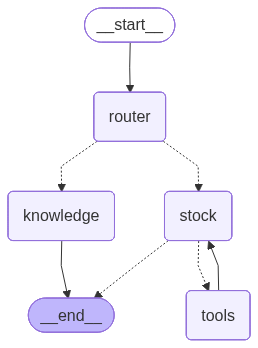

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [11]:
result = graph.invoke(
    State(messages=[{"role": "user", "content": "What is the price of AAPL stock?"}])
)


for msg in reversed(result["messages"]):
    if msg["role"] == "assistant" and msg["content"]:
        print(msg["content"])
        break


The current price of AAPL stock is $100.4.


In [12]:
result = graph.invoke(
    State(messages=[
        {"role": "user", "content": "Explain what LangGraph is in simple terms"}
    ])
)

for msg in reversed(result["messages"]):
    if msg["role"] == "assistant" and msg["content"]:
        print(msg["content"])
        break


LangGraph is a tool or framework designed to help people work with language and data more effectively. It combines concepts from language processing and graph theory to create a structure that makes it easier to analyze and understand relationships between different pieces of information. 

In simple terms, you can think of LangGraph as a way to visualize and connect words, phrases, or concepts like a map, helping users see how they relate to each other. This can be useful for tasks like improving communication, organizing information, or even building applications that understand human language better.


In [13]:
import gradio as gr

def chat(user_input, history):
    # Invoke LangGraph
    result = graph.invoke(
        State(messages=[
            {"role": "user", "content": user_input}
        ])
    )

    # Extract last assistant message safely
    for msg in reversed(result["messages"]):
        if msg["role"] == "assistant" and msg["content"]:
            return msg["content"]

    return "No response generated."


/Users/sandhyabantiduttaborah/Desktop/langgraph_cb/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
gr.ChatInterface(
    fn=chat,
    title="🧠 Multi-Agent Chatbot",
    description="Routes between Knowledge Agent and Stock Agent (Mock Tool)",
).launch(inline=True)


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
